# Imports

In [1]:
import pandas as pd
import numpy as np
import os,  sys

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from mpl_toolkits import mplot3d

# !pip install ipympl

# Find path to .py files
sys.path.append('/Users/benjaminwong/JupyterNotebooks/masters_pfti/notebooks/python/')

from hetanalysis import HetAnalysis
from clean import DrawPointAssayCleaner, DrawPointCoordCleaner
import plotter

output_dir = "../outputs/het_analysis_dp_assay/"
SAVE = False

plt.rcParams.update(
    {
        'font.size': 22
    }
)

%matplotlib widget

# Data input and cleaning

In [2]:
df = DrawPointAssayCleaner.get_processed_data()
dp_coords = DrawPointCoordCleaner.get_processed_data()

['CU', 'AU', 'AG', 'PB', 'ZN']


# Group

In [3]:
elements = [
    'CU', 
    'AU', 
    'AG'
]

groups = {}
dhids = df['dhid'].unique()

invalid, valid = [], []

for dhid in dhids:
    filtered_df = df.query('dhid == @dhid')
    groups[dhid] = {}
    
    for element in elements:
        try:
            groups[dhid][element] = HetAnalysis(f'{dhid}_{element}', filtered_df['weight'], filtered_df[element])
            valid.append(f'{dhid}_{element}')
        except:
            invalid.append(f'{dhid}_{element}')
            

# Output

Save each element in each drillhole grouping as a separate G-R graph when possible

In [4]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)

    for dhid, group in groups.items():
        save_loc = output_dir + f'{dhid}/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)

        for element in elements:
            if element in group:
                fig.clear()
                ax = fig.add_subplot()

                het = group[element].get_heterogeneity()
                info = group[element].get_info()
                
                if len(info) > 0:
                    ax.set_title(f'{dhid}_{element}_HET={het:.2f}')
                    ax_sec = ax.twinx()
                    
                    plotter.plot_g_r(ax, ax_sec, info, ls='--')
                    plotter.scatter_g_r(ax, ax_sec, info)
                    
                    plotter.set_g_r_labels(ax, ax_sec, element)
                    ax.grid()

                    fig.tight_layout()
                    fig.savefig(save_loc + f'{dhid}_{element}.svg', format='svg')

In [5]:
# then we want to graph the mass yield curves for all the individual elements

if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)

    s = 0.5
    alpha = 0.4

    for element in elements:
        fig.clear()
        ax = fig.add_subplot()
        ax.set_ylim([0, 10])
        
        ax_sec = ax.twinx()

        for group in groups.values():
            if element in group:
                plotter.scatter_g_r(ax, ax_sec, group[element].get_info(), s=s, alpha=alpha)
                
        plotter.set_g_r_labels(ax, ax_sec, element)
        ax.set_title(f'master_{element}')

        save_loc = output_dir + f'master/'
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
            
        fig.tight_layout()
        fig.savefig(save_loc + f'master_{element}.png', format='png', dpi=200)

In [6]:
combined_data = {}

for element in elements:
    combined_data[element] = HetAnalysis(element, df['weight'], df[element])

In [7]:
if SAVE:
    fig = plt.figure()
    fig.set_size_inches(10, 8)

    for element in elements:
        fig.clear()
        ax = fig.add_subplot()
        ax.set_ylim([0, 5])

        het = combined_data[element].get_heterogeneity()
        info = combined_data[element].get_info()
        
        if len(info) > 0:
            ax.set_title(f'combined_{element}_HET={het:.2f}')
            ax.set_ylim([0, 5])
            
            ax_sec = ax.twinx()
            
            plotter.plot_g_r(ax, ax_sec, info)
            
            plotter.set_g_r_labels(ax, ax_sec, element)
            ax.grid()
            
            save_loc = output_dir + f'combined/'
            if not os.path.exists(save_loc):
                os.makedirs(save_loc)
                
            fig.tight_layout()
            fig.savefig(save_loc + f'combined_{element}.png', format='png', dpi=200)

# Visualize

In [8]:
for dhid in groups.keys():
    if dhid not in list(dp_coords.index):
        print(f'{dhid}')

In [9]:
hs = {}
for element in elements:
    hs[element] = {
        'nan': set(),
        'het': set()
    }
    for dpid in list(dp_coords.index):
        if dpid not in groups:
            hs[element]['nan'].add(dpid)
        else:
            if element in groups[dpid]:
                hs[element]['het'].add(dpid)
            else:
                hs[element]['nan'].add(dpid)

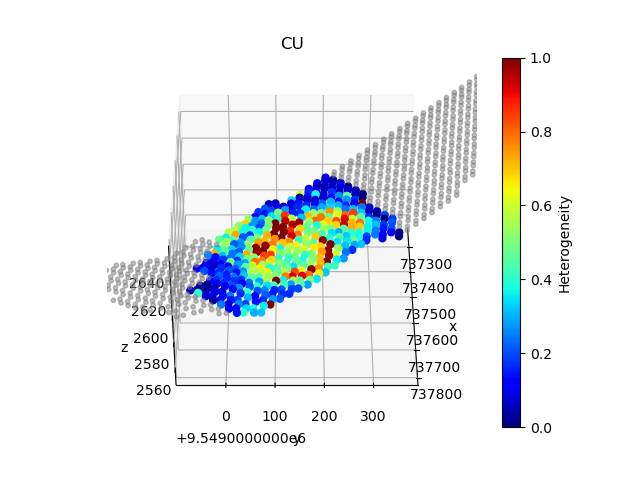

In [10]:
fig = plt.figure()
ax = plt.axes(projection='3d')

element = 'CU'

nan_dps = hs[element]['nan']
het_dps = hs[element]['het']

cmap = plt.colormaps.get('jet')

p = ax.scatter3D(
    [dp_coords.loc[dpid]['x'] for dpid in het_dps], 
    [dp_coords.loc[dpid]['y'] for dpid in het_dps],
    [dp_coords.loc[dpid]['z'] for dpid in het_dps], 
    c=[groups[dpid][element].get_heterogeneity() for dpid in het_dps],
    vmax=1,
    cmap=cmap,
    s=25,
    alpha=1
)

# Set limits to the non-nan values
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.set_zlim([2550, 2650])

ax.scatter3D(
    [dp_coords.loc[dpid]['x'] for dpid in nan_dps], 
    [dp_coords.loc[dpid]['y'] for dpid in nan_dps],
    [dp_coords.loc[dpid]['z'] for dpid in nan_dps], 
    s=10,
    alpha=0.5,
    c='grey'
)

ax.set_title(element)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.azim = 0
ax.elev = 40

cbar = fig.colorbar(p)
cbar.set_label('Heterogeneity')

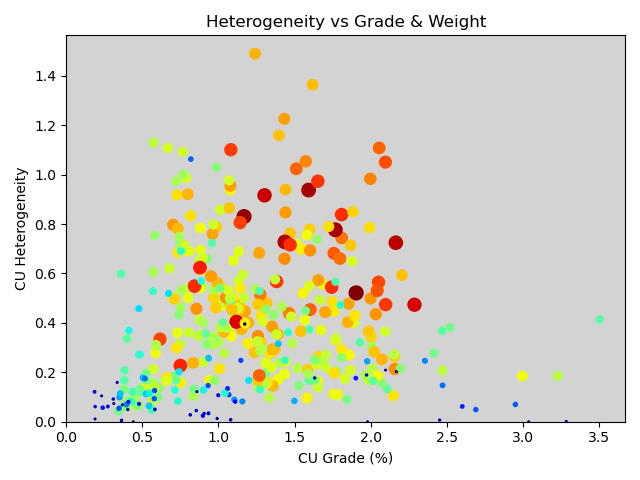

In [11]:
element = 'CU'

x, y, w = [], [], []

for dhid, group in groups.items():
    x.append(group[element].get_grade())
    y.append(group[element].get_heterogeneity())
    w.append(group[element].get_cml_weight())
    
max_w = np.max(w)
scaled_w = 1 + (9 * (w / max_w))


fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_w**2, c=w, cmap=plt.colormaps.get('jet'))

ax.set_xlabel(f'{element} Grade (%)')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Heterogeneity')
ax.set_ylim(0, None)

ax.set_title('Heterogeneity vs Grade & Weight')
ax.set_facecolor('lightgrey')

fig.tight_layout()

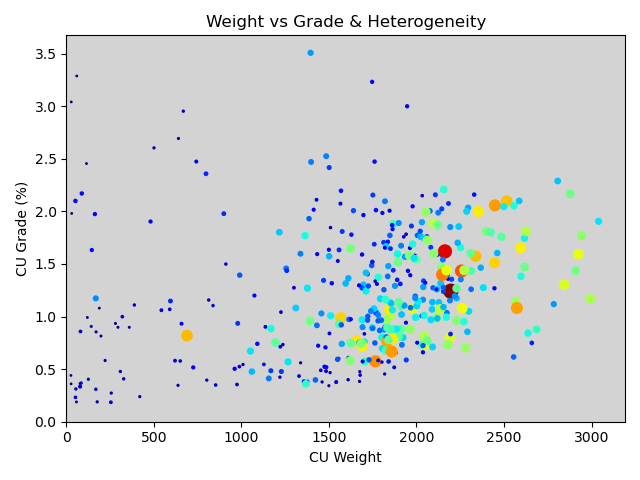

In [12]:
element = 'CU'

x, y, h = [], [], []

for dhid, group in groups.items():
    y.append(group[element].get_grade())
    x.append(group[element].get_cml_weight())
    h.append(group[element].get_heterogeneity())
    
max_h = np.max(h)
scaled_h = 1 + (9 * (h / max_h))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(x, y, s=scaled_h**2, c=h, cmap=plt.colormaps.get('jet'))

ax.set_xlabel(f'{element} Weight')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Grade (%)')
ax.set_ylim(0, None)

ax.set_title('Weight vs Grade & Heterogeneity')
ax.set_facecolor('lightgrey')

fig.tight_layout()

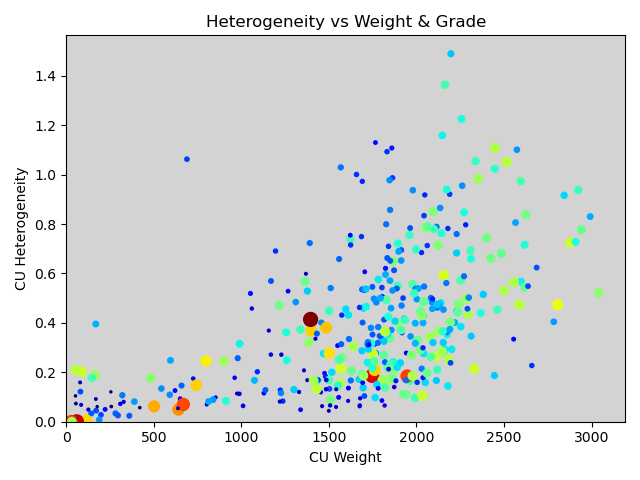

In [13]:
element = 'CU'

g = [group[element].get_grade() for group in groups.values()]

scaled_g = 1 + (9 * (g / np.max(g)))

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(
    [group[element].get_cml_weight() for group in groups.values()], 
    [group[element].get_heterogeneity() for group in groups.values()], 
    s=scaled_g**2, 
    c=g, 
    cmap=plt.colormaps.get('jet')
)

ax.set_xlabel(f'{element} Weight')
ax.set_xlim(0, None)

ax.set_ylabel(f'{element} Heterogeneity')
ax.set_ylim(0, None)

ax.set_title('Heterogeneity vs Weight & Grade')
ax.set_facecolor('lightgrey')

fig.tight_layout()